In [15]:
train_label[:10]

[array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.])]

In [13]:
train_label = list(np.zeros((25000,1))) + list(np.ones((25000,1)))

In [36]:
import glob
import numpy as np
from pprint import pprint
import random

def shuffle_data(data, targets):    
    data_zip = list(zip(data, targets))
    random.shuffle(data_zip)
    data_shuffle, targets_shuffle = list(zip(*train_zip))
    return data_shuffle, targets_shuffle

# load data
data_path = 'data'

def load_data(kind):
    data = []
    
    for label in ('neg', 'pos'):
        files = glob.glob(data_path + f"/{kind}/{label}/*")
        assert(len(files) == 12500)
        for text_file in files:
            with open(text_file, 'r') as fin:
                data.append(fin.readline().strip())
                
    assert(len(data) == 25000)
    n_pos = 12500
    targets = list(np.zeros((n_pos))) + list(np.ones((n_pos)))
    
    return shuffle_data(data, targets)

train_data_pre, train_targets_pre = load_data('train')
test_data, test_targets = load_data('test')

In [37]:
# Split train data into actual train and validation sets
print ("Train dataset size is {}".format(len(train_data_pre)))
print ("Test dataset size is {}".format(len(test_data)))

train_split = 20000

val_data = train_data_pre[train_split:]
val_targets = train_targets_pre[train_split:]

train_data = train_data_pre[:train_split]
train_targets = train_targets_pre[:train_split]

print("After val split")
print ("Train dataset size is {}".format(len(train_data)))
print ("Val dataset size is {}".format(len(val_data)))
print ("Test dataset size is {}".format(len(test_data)))

Train dataset size is 25000
Test dataset size is 25000
After val split
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [38]:
# Random sample from train dataset
ix = random.randint(0, len(train_data) - 1)
print(f"Target: {train_targets[ix]}\n")
print (train_data[ix])

Target: 1.0

I decided to watch this because of the recommendations from this site. I would have to say it was worth the effort. However, you should take heed that this film will go on for 210 minutes. If you don't have the staying power, get it on tape and watch it over a couple of nights.<br /><br />Now to the film, what I say will contain "spoilers" and if you don't mind, here goes: <br /><br />Alexandre is a promiscuous bum, a womanizer and a gigolo. He lives with an older woman called Marie. Marie owns a retail shop and she provides for Alex. Alex spends his days at cafés and restaurants. The story reveals that Alex had previously impregnated Gilberte whom he used to live with. Gilberte dumped him for a less attractive man that she did not love because Alex had abused and battered her. At this point, Alex was willing to get a job and and help raise their child before he found out Gilberte had aborted it and planned to marry someone else. <br /><br />By chance, Alexandre meets a nu

Before training the classifier, first we are going to tokenize the dataset using spacy.io

Run (shown in the cell below):

* ```pip install spacy```
* ```python -m spacy download en_core_web_sm```

In [39]:
!pip install spacy
!python -m spacy download en_core_web_sm

smart-open 1.5.6 requires boto3, which is not installed.
You are using pip version 10.0.0, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.0, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

    Linking successful
    /Users/diogomesquita/anaconda/envs/py3.6/lib/python3.6/site-packages/en_core_web_sm
    -->
    /Users/diogomesquita/anaconda/envs/py3.6/lib/python3.6/site-packages/spacy/data/en_core_web_sm

    You can now load the model via spacy.load('en_core_web_sm')



data 

train_data_ix_{vocab_size}_{n}gram.pickle val_data_ix_{vocab_size}_{n}gram.pickle test_data_ix_{vocab_size}_{n}gram.pickle

In [17]:

# lowercase and remove punctuation
def tokenize(sent):
  tokens = tokenizer(sent)
  return [token.text.lower() for token in tokens if (token.text not in punctuations)]

# Example
tokens = tokenize(u'Apple is, looking ! at buying U.K. startup for $1 billion')
print (tokens)

['apple', 'is', 'looking', 'at', 'buying', 'u.k.', 'startup', 'for', '1', 'billion']


In [41]:
# This is the code cell that tokenizes train/val/test datasets
# However it takes about 15-20 minutes to run it
# For convinience we have provided the preprocessed datasets
# Please see the next code cell


def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

# val set tokens
#print ("Tokenizing val data")
#val_data_tokens, _ = tokenize_dataset(val_data)
#pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))

# test set tokens
#print ("Tokenizing test data")
#test_data_tokens, _ = tokenize_dataset(test_data)
#pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))

# train set tokens
#print ("Tokenizing train data")
#train_data_tokens, all_train_tokens = tokenize_dataset(train_data)
#pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))
#pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))

In [56]:
# Alternatively try running the following multi-threaded version of tokenization
# Credit to Ilya Kulikov
import pickle as pkl
import tqdm
import spacy
import string

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

def lower_case_remove_punc(parsed):
    return [token.text.lower() for token in parsed if (token.text not in punctuations)]

def tokenize_dataset(dataset):
    dataset_1gram = []
    dataset_2gram = []
    dataset_3gram = []
    dataset_4gram = []
    
    # we are keeping track of all tokens in dataset
    # in order to create vocabulary later
    all_1gram = []
    all_2gram = []
    all_3gram = []
    all_4gram = []

    for sample in tqdm.tqdm_notebook(tokenizer.pipe(dataset, disable=['parser', 'tagger', 'ner'], batch_size=512, n_threads=4)):
        tokens = lower_case_remove_punc(sample)
        
        dataset_1gram.append(tokens)
        all_1gram += tokens
        
        sent_2gram = [' '.join(tokens[i:i+2]) for i in range(len(tokens)-1)]
        dataset_2gram.append(sent_2gram)
        all_2gram += sent_2gram
        
        sent_3gram = [' '.join(tokens[i:i+3]) for i in range(len(tokens)-2)]
        dataset_3gram.append(sent_3gram)
        all_3gram += sent_3gram
        
        sent_4gram = [' '.join(tokens[i:i+4]) for i in range(len(tokens)-3)]
        dataset_4gram.append(sent_4gram)
        all_4gram += sent_4gram
        
    return [(dataset_1gram, all_1gram),
            (dataset_2gram, all_2gram),
            (dataset_3gram, all_3gram),
            (dataset_4gram, all_4gram)]
            

# val set tokens
print ("Tokenizing val data")
(val_data_1gram, _),\
(val_data_2gram, _),\
(val_data_3gram, _),\
(val_data_4gram, _) = tokenize_dataset(val_data)

pkl.dump([val_data_1gram, val_targets], open("data/processed/val_data_1gram.p", "wb"))
pkl.dump([val_data_2gram, val_targets], open("data/processed/val_data_2gram.p", "wb"))
pkl.dump([val_data_3gram, val_targets], open("data/processed/val_data_3gram.p", "wb"))
pkl.dump([val_data_4gram, val_targets], open("data/processed/val_data_4gram.p", "wb"))

# test set tokens
print ("Tokenizing test data")
(test_data_1gram, _),\
(test_data_2gram, _),\
(test_data_3gram, _),\
(test_data_4gram, _) = tokenize_dataset(test_data)

pkl.dump([test_data_1gram, test_targets], open("data/processed/test_data_1gram.p", "wb"))
pkl.dump([test_data_2gram, test_targets], open("data/processed/test_data_2gram.p", "wb"))
pkl.dump([test_data_3gram, test_targets], open("data/processed/test_data_3gram.p", "wb"))
pkl.dump([test_data_4gram, test_targets], open("data/processed/test_data_4gram.p", "wb"))

# train set tokens
print ("Tokenizing train data")
(train_data_1gram, all_train_1grams),\
(train_data_2gram, all_train_2grams),\
(train_data_3gram, all_train_3grams),\
(train_data_4gram, all_train_4grams) = tokenize_dataset(train_data)

pkl.dump([train_data_1gram, train_targets], open("data/processed/train_data_1gram.p", "wb"))
pkl.dump([train_data_2gram, train_targets], open("data/processed/train_data_2gram.p", "wb"))
pkl.dump([train_data_3gram, train_targets], open("data/processed/train_data_3gram.p", "wb"))
pkl.dump([train_data_4gram, train_targets], open("data/processed/train_data_4gram.p", "wb"))

pkl.dump(all_train_1grams, open("data/processed/all_train_1grams.p", "wb"))
pkl.dump(all_train_2grams, open("data/processed/all_train_2grams.p", "wb"))
pkl.dump(all_train_3grams, open("data/processed/all_train_3grams.p", "wb"))
pkl.dump(all_train_4grams, open("data/processed/all_train_4grams.p", "wb"))

print("Number of train 1grams: ", len(all_train_1grams))
print("Number of train 2grams: ", len(all_train_2grams))
print("Number of train 3grams: ", len(all_train_3grams))
print("Number of train 4grams: ", len(all_train_4grams))

Tokenizing val data


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Tokenizing test data


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Tokenizing train data


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Number of train 1grams:  4795739
Number of train 2grams:  4775739
Number of train 3grams:  4755739
Number of train 4grams:  4735739


To convert token to id in the dataset use the index_data.py file

Usage: python index_data.py ngrams max_vocab_size

Example: python index_data.py 2 10000

Now to train the model use the train.py file.

Usage: python train.py ngrams max_vocab_size embed_dim

Example: python train.py 4 50000 300

In [85]:
import torch
from torch.utils.data import DataLoader

from data import MovieReviewsDataset, moviereviews_collate_func
from model import BagOfWords
from train import test_model
# best model
ngram = 1
max_vocab_size = 50000
emb_dim = 100

test_data_indices, test_targets = pkl.load(open(f"data/processed/test_data_indicies_{ngram}gram_{max_vocab_size}vocab.p", "rb"))
BATCH_SIZE = 64
test_dataset = MovieReviewsDataset(test_data_indices, test_targets)
test_loader = DataLoader(dataset=test_dataset,
                           batch_size=BATCH_SIZE,
                           collate_fn=moviereviews_collate_func,
                           shuffle=True)

model = BagOfWords(max_vocab_size+2, emb_dim)
model.load_state_dict(torch.load(f"models/model_{ngram}gram_{max_vocab_size}vocab_{emb_dim}embed.pth"))

test_acc = test_model(test_loader, model)
print("Test accuracy: ", test_acc)

Test accuracy:  94.936


In [75]:
%%bash -s "$ngram" "$max_vocab_size" "$emb_dim"
ngram=$1
max_vocab_size=$2
emb_dim=$3

file="logs/train/train_${ngram}_${max_vocab_size}_${emb_dim}.out"

grep "Validation Acc" $file | awk '{print $7}' > val_curve.txt
grep "Train Acc" $file | awk '{print $7}' > train_curve.txt


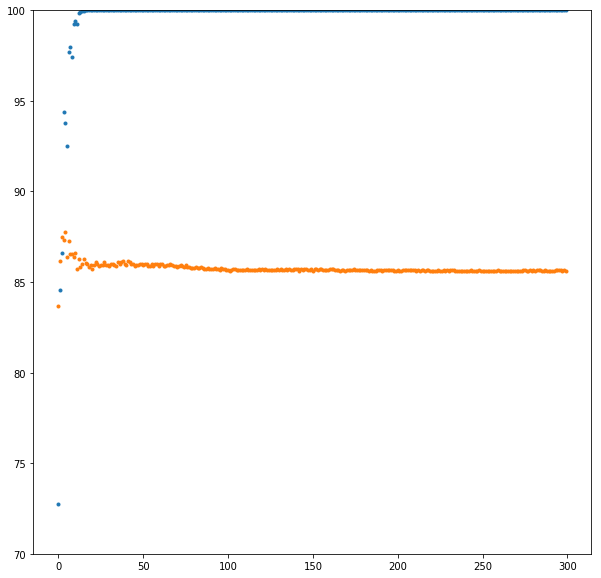

In [95]:
# after training plot curves of best model
import matplotlib.pyplot as plt
%matplotlib inline


with open('train_curve.txt', 'r') as fin:
    train_curve = [float(line.strip()) for line in fin]
    
with open('val_curve.txt', 'r') as fin:
    val_curve = [float(line.strip()) for line in fin]

fig, ax1 = plt.subplots(1,1, figsize=(10,10))
ax1.plot(train_curve, '.')
ax1.set_ylim(70, 100)
ax1.plot(val_curve, '.')
plt.savefig('train_curves')

In [ ]:
len(train_curve)